# Data Augmentation examples

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import sys
import os
import time
import torch
sys.path.append('\\'.join(os.getcwd().split('\\')[:-1])+'\\src')

import utils as c_utils
import dataset as c_dataset

from tqdm import tqdm
from torchvision import transforms
from torch.utils.data import dataloader
from albumentations import (
    VerticalFlip, HorizontalFlip, IAAPerspective, ShiftScaleRotate, CLAHE, RandomRotate90,
    Transpose, ShiftScaleRotate, Blur, OpticalDistortion, GridDistortion, HueSaturationValue,
    IAAAdditiveGaussianNoise, GaussNoise, MotionBlur, MedianBlur, IAAPiecewiseAffine,
    IAASharpen, IAAEmboss, RandomBrightnessContrast, Flip, OneOf, Compose
)

### Load data

In [2]:
IMAGE_PATH = '../data/train_images'
DATA_PATH = '../data/multiData'
METADATA_PATH = '../data/multiData/train_data.csv'

INPUT_PATH = DATA_PATH + '/' + 'X_train.pth' 
LABEL_PATH = DATA_PATH + '/' + 'y_train.pth'
MASK_PATH  = DATA_PATH + '/' + 'M_train.pth'

In [3]:
N_CLASSES = 5
params = c_utils.get_default_params()
device = torch.device('cuda')
params

{'size': (64, 400),
 'mask_size': (64, 400),
 'mean': [0.485, 0.456, 0.406],
 'std': [0.229, 0.224, 0.225],
 'colors': [[0, 0.25, 0.25],
  [0.25, 0.0, 0.0],
  [0.0, 0.25, 0.0],
  [0.0, 0.0, 0.25]]}

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


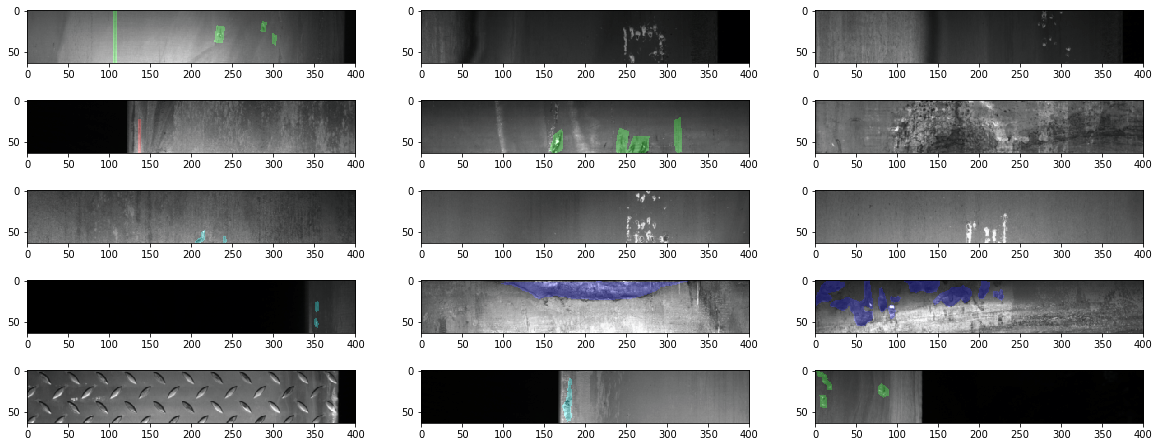

In [4]:
X_t, y_t, M_t = torch.load(INPUT_PATH), torch.load(LABEL_PATH), torch.load(MASK_PATH)
fig, ax = plt.subplots(5, 3, figsize=(20, 8))
for i in range(5):
    for j in range(3):
        n = i*3 + j
        img = np.transpose(X_t[n].numpy(), (1, 2, 0))*params['std'] + params['mean']
        mask = M_t[n].reshape(*params['size'])
        if y_t[n] > 0:
            img[mask == 1] = img[mask == 1] + params['colors'][y_t[n]-1]
        ax[i, j].imshow(img)
plt.show()

### 1. Noise Augmentation


Noise augmentation is done by adding some random noise into the input. Since the process is very fast to do, we apply the noise on the fly during training. By addinng noise to an input $X$, we get a new inout $X'$ such that:

$\begin{equation*} X' = X + \lambda Z, \hspace{2mm} where \hspace{2mm} Z \sim \mathcal{N}\big(\mathbf{0}, I_d\big), \lambda \in \mathbb{R}\end{equation*}$

### 2. Augmentation: Horizontal and Vertical Flip

We perform Horiziontal and Verical Flip Sequentially with probability $p$ on all the images belonging to underepresented class (class 1, 2, 4). We performe this action two times such that we start from one image and we end with tree (the original plus the two augmented). 

#### Theorem: best probability for ending with three different images.

Let $X$ be an input, $A$ a process composed with two indipendent augmentations $a1, a2$, which happen with probability $p$. If we feed to this process $X$ two times we get two output $Y_1$ and $Y_2$.

We know want to compute the proability that:

$Y_1 \neq Y_2 \neq X$

If we denote $A_i \in [0, 1]^j = [0, 1]^2$ as the vector which specifies the output $Y_i$, since the two components take value 0 if the augmentation $a_j$ did not happened or 1 if it has happened, we can compute this probability by solving the following equation, which sum all the possible accepted events:

$P(A_1=(0,1))\cdot P(A_2=(1,0)) + P(Y_1=(1,0))\cdot P(Y_2=(0,1)) + P(Y_1=(1,1))\cdot P(Y_2=(0,1)) + P(Y_1=(1,1))\cdot P(Y_2=(0,1)) + P(Y_1=(0,1))\cdot P(Y_2=(1,1)) + P(Y_1=(1,0))\cdot P(Y_2=(1,1)) = 2((1-p)p)^2 + 4p^3(1-p) =: f(p)$

We can then maximise this procedure by finding the root $\hat{x}$ of the first derivative ($f'(\hat{x}) = 0$).
In this case this happens when $\hat{x} = \frac{1}{\sqrt 2}$

In [ ]:
augmentator = c_dataset.Augmentator(p=1/(2**0.5), times_to_augment=[2, 6, 2])
aug_X, aug_y, aug_M = augmentator(X_t, y_t, M_t)

### Visualize results

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


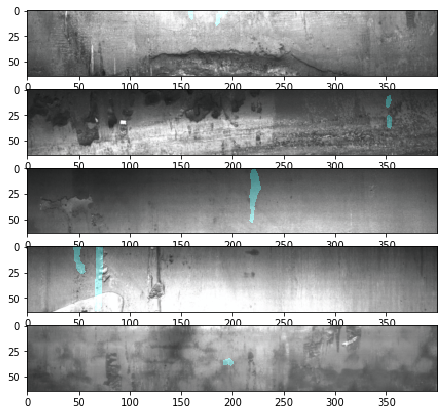

In [23]:
fig, ax = plt.subplots(5, 1, figsize=(20, 7))
for j in range(5):
        img = np.transpose(aug_X[aug_y==4][j].numpy(), (1, 2, 0))*params['std'] + params['mean']
        mask = aug_M[j].reshape(*params['size'])
        img[mask == 1] = img[mask == 1] + params['colors'][aug_y[j]-1]
        ax[j].imshow(img)
plt.show()

### 3. Sliding Windows: dividing images in 6 patches

In [6]:
sliding = c_dataset.SlidingWindow(X_t, y_t, M_t)
X_slided = torch.empty((X_t.shape[0]*6, 3, 64, 64))
y_slided = torch.empty((X_t.shape[0]*6)).long()
M_slided = torch.empty((X_t.shape[0]*6, 64, 64)).long()
batch_size = 30
loader = dataloader.DataLoader(sliding, batch_size)
for n, batch in tqdm(enumerate(loader)):
    X_batch, y_batch, M_batch = batch
    bs = y_batch.shape[0]
    X_slided[n*6*batch_size:n*6*batch_size + bs*6] = X_batch.view(bs*6, 3, 64, 64)
    y_slided[n*6*batch_size:n*6*batch_size + bs*6] = y_batch.view(bs*6)
    M_slided[n*6*batch_size:n*6*batch_size + bs*6] = M_batch.view(bs*6, 64, 64)

243it [00:39,  6.13it/s]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


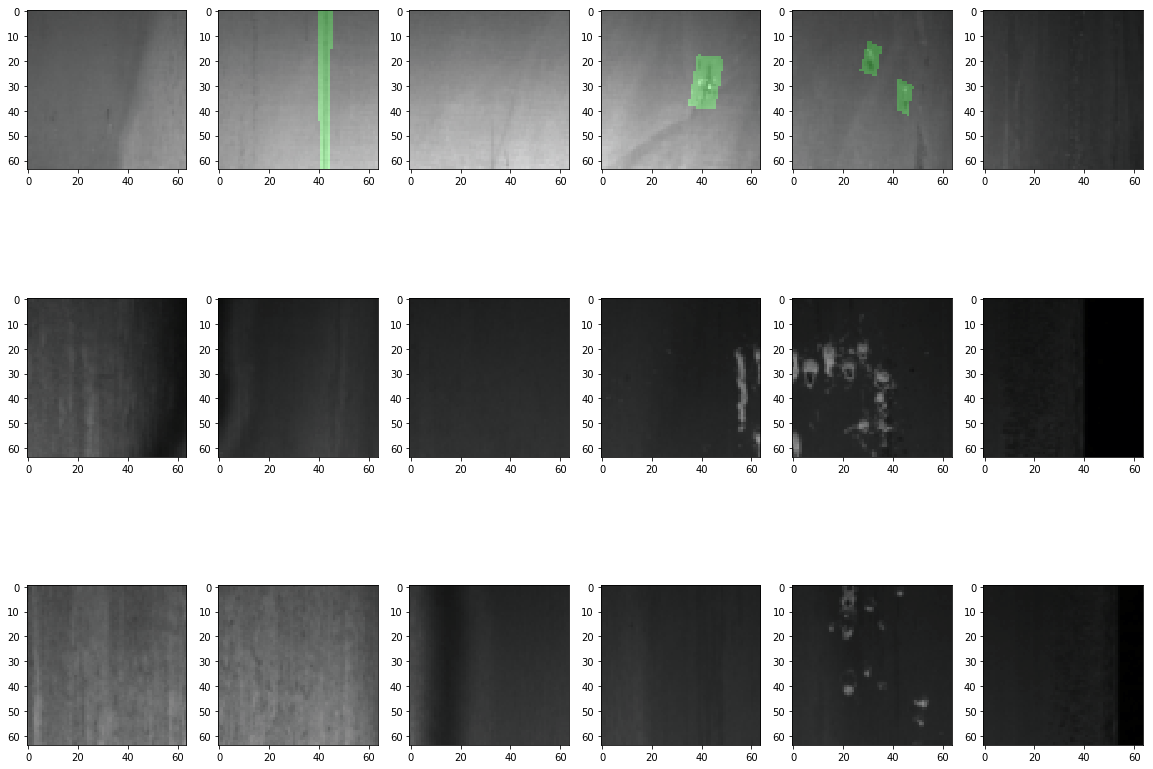

In [7]:
fig, ax = plt.subplots(3, 6, figsize=(20, 15))
for i in range(3):
    for j in range(6):
        n = i*6 + j
        img = np.transpose(X_slided[n].numpy(), (1, 2, 0))*params['std'] + params['mean']
        mask = M_slided[n]
        if y_slided[n] > 0:
            img[mask == 1] = img[mask == 1] + params['colors'][y_slided[n]-1]
        ax[i, j].imshow(img)
plt.show()

### Remove black images

Black images have mean value usually under -1.8. We can remove a major subsect of them using this info

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


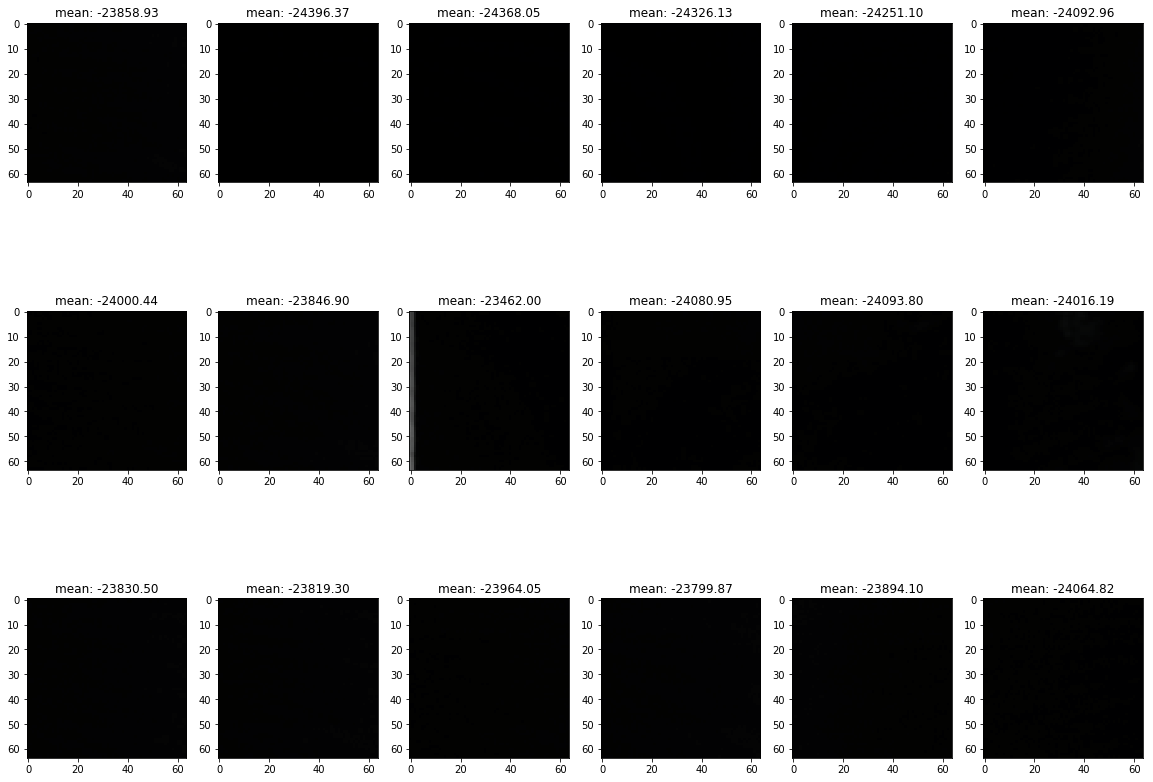

In [12]:
mean = X_slided.mean(axis=(1,2,3))
X_b = X_slided[mean < -1.85]
y_b = y_slided[mean < -1.85]
M_b = M_slided[mean < -1.85]

fig, ax = plt.subplots(3, 6, figsize=(20, 15))
for i in range(3):
    for j in range(6):
        n = i*6 + j
        img = np.transpose(X_b[n].numpy(), (1, 2, 0))*params['std'] + params['mean']
        mask = M_b[n]
        if y_b[n] > 0:
            img[mask == 1] = img[mask == 1] + params['colors'][y_b[n]-1]
        ax[i, j].imshow(img)
        ax[i, j].set_title('mean: {:.2f}'.format(X_b[n].sum()))
plt.show()

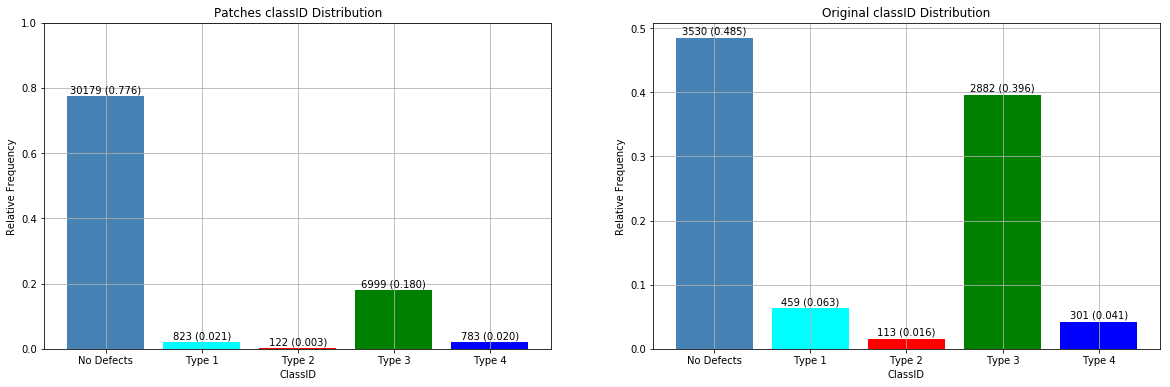

In [9]:
df = pd.Series(y_slided[mean >= -1.85].numpy())
fig, ax = plt.subplots(1, 2, figsize = (20, 6))
class_dist = df.value_counts().sort_index()
ClassId2ClassName = {0: 'No Defects', 1:'Type 1', 2:'Type 2', 3:'Type 3', 4:'Type 4'}
bar1 = ax[0].bar(ClassId2ClassName.values(), class_dist/class_dist.sum(),
                 color=['steelblue', 'cyan', 'red', 'green', 'blue'])
ax[0].set_title('Patches classID Distribution')
ax[0].set_ylabel('Relative Frequency')
ax[0].set_xlabel('ClassID')
ax[0].grid()
ax[0].set_ylim([0, 1])

for i, rect in enumerate(bar1):
    height = rect.get_height()
    text = '{} ({:.3f})'.format(class_dist.values[i], height)
    ax[0].text(rect.get_x() + rect.get_width()/2.0, height+0.003, text, ha='center', va='bottom')

class_dist = pd.Series(y_t.numpy()).value_counts().sort_index()
ClassId2ClassName = {0: 'No Defects', 1:'Type 1', 2:'Type 2', 3:'Type 3', 4:'Type 4'}
bar1 = ax[1].bar(ClassId2ClassName.values(), class_dist/class_dist.sum(),
                 color=['steelblue', 'cyan', 'red', 'green', 'blue'])
ax[1].set_title('Original classID Distribution')
ax[1].set_ylabel('Relative Frequency')
ax[1].set_xlabel('ClassID')
ax[1].grid()

for i, rect in enumerate(bar1):
    height = rect.get_height()
    text = '{} ({:.3f})'.format(class_dist.values[i], height)
    ax[1].text(rect.get_x() + rect.get_width()/2.0, height+0.003, text, ha='center', va='bottom')
plt.show()